# ロスカット分析

### プロジェクトのルートのパスを通す

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリを一括インポート

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.tide import get_date_str_from_file
from funcs.tse import get_ticker_name_list
from structs.res import AppRes

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

## CSV ファイル（取引明細）一覧の取得

In [4]:
res = AppRes()

code = "7011"  # 銘柄コード
# code = "8306"  # 銘柄コード

doe = "por"
# doe = "lc_00"
# doe = "lc_05"
# doe = "lc_10"
# doe = "lc_15"
# doe = "lc_20"
# doe = "lc_25"
# doe = "lc_30"
# doe = "lc_35"
# doe = "lc_40"
# doe = "lc_45"
# doe = "lc_50"

dict_name = get_ticker_name_list([code])
print(dict_name)
dir_transaction = os.path.join("..", res.dir_transaction, code, doe)

list_file = sorted(os.listdir(dir_transaction))
date_str = get_date_str_from_file(list_file[-1])
print(date_str)

print("\n分析対象の取引明細ファイル")
print(list_file)
n_day = len(list_file)
print(f"# of transaction files : {n_day}")

{'7011': '三菱重工業'}
20251225

分析対象の取引明細ファイル
['por_20250819.csv', 'por_20250820.csv', 'por_20250821.csv', 'por_20250822.csv', 'por_20250825.csv', 'por_20250826.csv', 'por_20250827.csv', 'por_20250828.csv', 'por_20250829.csv', 'por_20250901.csv', 'por_20250902.csv', 'por_20250903.csv', 'por_20250904.csv', 'por_20250905.csv', 'por_20250908.csv', 'por_20250909.csv', 'por_20250910.csv', 'por_20250911.csv', 'por_20250912.csv', 'por_20250916.csv', 'por_20250917.csv', 'por_20250918.csv', 'por_20250919.csv', 'por_20250922.csv', 'por_20250924.csv', 'por_20250925.csv', 'por_20250926.csv', 'por_20250929.csv', 'por_20250930.csv', 'por_20251001.csv', 'por_20251002.csv', 'por_20251003.csv', 'por_20251006.csv', 'por_20251007.csv', 'por_20251008.csv', 'por_20251009.csv', 'por_20251010.csv', 'por_20251014.csv', 'por_20251015.csv', 'por_20251016.csv', 'por_20251017.csv', 'por_20251020.csv', 'por_20251021.csv', 'por_20251022.csv', 'por_20251023.csv', 'por_20251024.csv', 'por_20251027.csv', 'por_20251028.csv

## CSV ファイルの読み込みとデータフレームの結合

In [5]:
list_df = list()
for file in list_file:
    path_csv = os.path.join(dir_transaction, file)
    df = pd.read_csv(path_csv)
    if len(df) > 0:
        list_df.append(df)
df_transaction = pd.concat(list_df).dropna(how="any")
df_transaction.reset_index(inplace=True, drop=True)
df_transaction

,注文日時,銘柄コード,売買,約定単価,約定数量,損益
0,2025-08-19 09:24:08,7011,買埋,3954.0,1,61.0
1,2025-08-19 09:55:04,7011,売埋,3914.0,1,-5.0
2,2025-08-19 10:51:38,7011,売埋,3937.0,1,5.0
3,2025-08-20 09:04:33,7011,買埋,3812.0,1,0.0
4,2025-08-20 09:05:13,7011,売埋,3801.0,1,-12.0
...,...,...,...,...,...,...
650,2025-12-23 09:09:19,7011,売埋,3894.0,1,4.0
651,2025-12-24 09:01:20,7011,買埋,3903.0,1,2.0
652,2025-12-24 09:01:27,7011,売埋,3907.0,1,3.0
653,2025-12-24 09:01:34,7011,買埋,3904.0,1,3.0


## 損益分布（通期の個々の取引から）

In [6]:
title_scope = (
    "          "
    f"{dict_name[code]} ({code}): "
    f"{doe.upper()} / 返済 {len(df_transaction)} 回 / {n_day} 日"
)
v_total = df_transaction["損益"].sum()
v_mean = df_transaction["損益"].mean()
v_max = df_transaction["損益"].max()
v_min = df_transaction["損益"].min()
n_bin = int(v_max - v_min)
print("bins", n_bin)
v_sigma = df_transaction["損益"].std()

bins 175


../output/20251225_7011_losscut_por.png


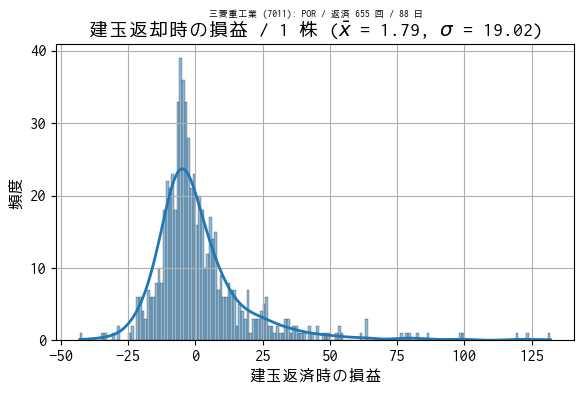

In [7]:
range_x = (np.float64(-51.75), np.float64(140.75))

plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_transaction,
    x="損益",
    bins=n_bin,
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(
    f"建玉返却時の損益 / 1 株 "
    f"($\\bar{{x}}$ = {v_mean:.2f}, $\\sigma$ = {v_sigma:.2f})"
)
ax.set_xlabel("建玉返済時の損益")
ax.set_ylabel("頻度")
ax.set_xlim(*range_x)

plt.tight_layout()
output = os.path.join("..", "output", f"{date_str}_{code}_losscut_{doe}.png")
print(output)
plt.suptitle(title_scope, fontsize=7)
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()